# Machine Learning and Statistics: Hands On 1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

## Model Building

We will build models for a triggered photon counter with a fixed exposure time. Assume that the number of photons $n$ entering the detector follows a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution):
$$
P(n\mid \lambda) = e^{-\lambda}\, \frac{\lambda^n}{n!}
$$
You will first create a **probabilistic model** for this photon counter, i.e., code to evaluate the likelihood $P(n\mid \lambda)$.

### Exercise 1

Fill in the function below to calculate $\log P(n\mid \lambda)$ without using any statistical libraries.

Notes:
 - `lambda` is a reserved keyword in python, so we use `lam` instead.
 - Use [scipy.special.gammaln](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammaln.html) to evaluate $\log n! = \log\Gamma(n + 1)$.

In [2]:
import scipy.special

In [3]:
def log_likelihood(n, lam):
    assert n >= 0
    return -lam + n * np.log(lam) - scipy.special.gammaln(n + 1)

Check that your probabilities are correctly normalized:

In [4]:
for lam in 0.5, 1., 2.:
    probs = [np.exp(log_likelihood(n, lam)) for n in range(100)]
    print(f'lam={lam}, sum of probs={np.sum(probs):.5f}')

lam=0.5, sum of probs=1.00000
lam=1.0, sum of probs=1.00000
lam=2.0, sum of probs=1.00000


Now reimplement your function to use [scipy.stats.poisson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html):

In [5]:
def log_likelihood(n, lam):
    assert n >= 0
    return scipy.stats.poisson.logpmf(n, lam)

Again, check that your probabilities are correctly normalized:

In [6]:
for lam in 0.5, 1., 2.:
    probs = [np.exp(log_likelihood(n, lam)) for n in range(100)]
    print(f'lam={lam}, sum of probs={np.sum(probs):.5f}')

lam=0.5, sum of probs=1.00000
lam=1.0, sum of probs=1.00000
lam=2.0, sum of probs=1.00000


Finally, modify your model to account for your counter's trigger, which only outputs a value of $n$ when at least one photon is detected $n \ge 1$.

In [7]:
def log_likelihood(n, lam):
    assert n >= 1
    return scipy.stats.poisson.logpmf(n, lam) - np.log(1 - np.exp(-lam))

Check that your probabilities are correctly normalized for $n \ge 1$:

In [8]:
for lam in 0.5, 1., 2.:
    probs = [np.exp(log_likelihood(n, lam)) for n in range(1, 100)]
    print(f'lam={lam}, sum of probs={np.sum(probs):.5f}')

lam=0.5, sum of probs=1.00000
lam=1.0, sum of probs=1.00000
lam=2.0, sum of probs=1.00000


### Exercise 2

Next, build a corresponding **generative model** by completing the function below.

Notes:
 - Use `scipy.stats.poisson` again.
 - You should never return $n=0$ since you are simulating a **triggered** counter.

In [9]:
def generate(lam, random_state):
    """Generative model of triggered photon counter.
    
    Parameters
    ----------
    lam : float
        Mean number of photons received during an exposure (without a trigger).
    random_state : numpy random_state object
        Random state to use for reproducible random numbers.
        
    Returns
    -------
    int
        Number of generated photons.
    """
    n = 0
    while n == 0:
        n = scipy.stats.poisson.rvs(lam, random_state=random_state)
    return n

Generate some random samples:

In [10]:
lam=2
random_state = np.random.RandomState(seed=123)
samples = np.array([generate(lam, random_state) for sample in range(10000)])

Check that your trigger is working:

In [11]:
assert np.all(samples > 0)

Check that your samples have the expected mean:

In [12]:
assert np.allclose(np.mean(samples), lam / (1 - np.exp(-lam)), atol=1e-2)

## Gaussian Mixtures

Read some of the overlapping sources data we generated earlier:

In [13]:
sources_4 = pd.read_hdf('data/sources_4_xy.hf5')
sources_5 = pd.read_hdf('data/sources_5_xy.hf5')
sources_8 = pd.read_hdf('data/sources_8_xy.hf5')

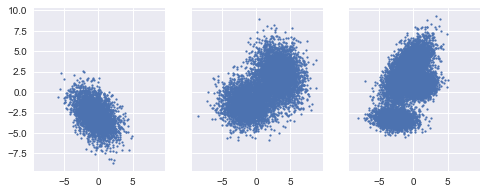

In [14]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8, 3))
for col, data in enumerate((sources_4, sources_5, sources_8)):
    ax[col].scatter(data.iloc[:, 0], data.iloc[:, 1], s=5, lw=0)

Recall that we can fit a mixture of Gaussians to each of these datasets, e.g.

In [15]:
from sklearn import mixture

In [16]:
fit = mixture.GaussianMixture(n_components=2).fit(sources_5)

To display the fit results:

In [17]:
from mls import display_gmm

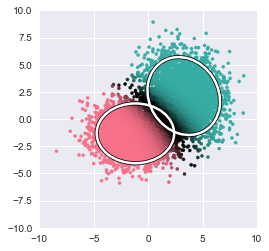

In [18]:
display_gmm(sources_5, fit)

This is all fine if you know in advance how many sources the data contains, but you usually don't for interesting problems.

A popular method for selecting the "best" number of Gaussian is to use the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) and [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion). These are different measures of the "goodness of fit" of the GMM to the data.  They both reward small residuals while penalizing extra fit parameters. However, both methods are ad-hoc and you should prefer (much more expensive) [Bayesian model selection methods](https://github.com/dkirkby/MachineLearningStatistics/blob/master/notebooks/ModelSelection.ipynb) when the answer really matters, or you need uncertainty estimates.

### Exercise 3

Use the methods `fit.aic()` and `fit.bic()` to plot the AIC and BIC for `n_components=1,2,3,4` with each of these three datasets.

In [19]:
def plot_criteria(data):
    aic, bic = [], []
    n_components = [1, 2, 3, 4]
    for n in n_components:
        fit = mixture.GaussianMixture(n_components=n).fit(data)
        aic.append(fit.aic(data))
        bic.append(fit.bic(data))
    plt.plot(n_components, aic, 'o-', label='AIC')
    plt.plot(n_components, bic, 'o-', label='BIC')
    plt.legend()

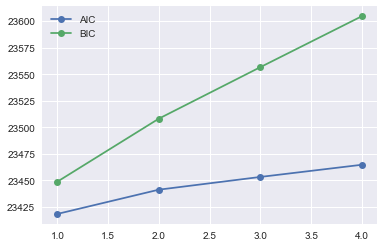

In [20]:
plot_criteria(sources_4)

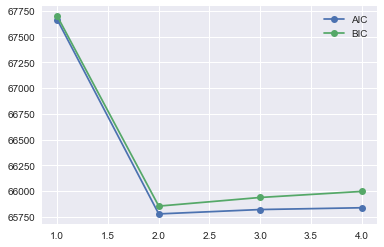

In [21]:
plot_criteria(sources_5)

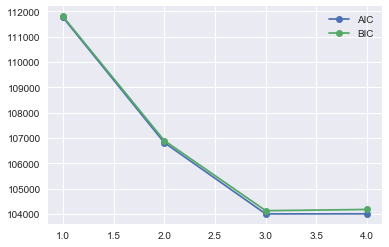

In [22]:
plot_criteria(sources_8)

## Expectation Maximization

The [Expectation-Maximization (EM) algorithm](https://en.wikipedia.org/wiki/Expectation-maximization_algorithm) is used to implement many machine learning methods, including several we have already studied: K-means, factor analysis and weighted PCA.

The basic idea of EM is to optimize a goal function that depends on two disjoint sets of parameters by alternately updating one set and then the other, using a scheme that is guaranteed to improve the goal function (although generally to a local rather than global optimum). The alternating updates are called the E-step and M-step.

The K-means is one of the simplest uses of EM, so is a good way to get some hands-on experience.

### Exercise 4

Implement the function below to perform a K-means E-step. Hint: you might find [np.argmin](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argmin.html) useful.

In [23]:
def E_step(X, centers):
    """Perform a K-means E-step.
    
    Assign each sample to the cluster with the nearest center, using the
    Euclidean norm to measure distance between a sample and a cluster center.
    
    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    centers : array with shape (n, D)
        Centers of the the n clusters in D dimensions.
        
    Returns
    -------
    integer array with shape (N,)
        Cluster index of each sample, in the range 0 to n-1.
    """
    N, D = X.shape
    n = len(centers)
    assert centers.shape[1] == D
    indices = np.empty(N, int)
    ### BEGIN SOLUTION
    for i in range(N):
        distance_squared = np.sum((X[i] - centers) ** 2, axis=1)
        indices[i] = np.argmin(distance_squared)
    ### END SOLUTION
    return indices

In [24]:
# A correct solution should pass these tests.
gen = np.random.RandomState(seed=123)
X = gen.normal(size=(20, 2))
centers = np.array([[0., 0.], [0., 10.]])
X[50:] += centers[1]
indices = E_step(X, centers)
assert np.all(indices[:50] == 0)
assert np.all(indices[50:] == 1)

centers = gen.uniform(size=(5, 2))
indices = E_step(X, centers)
assert np.array_equal(indices, [4, 1, 4, 4, 1, 0, 1, 0, 2, 1, 2, 4, 0, 1, 0, 1, 0, 1, 4, 4])

Next, implement the function below to perform a K-means M-step:

In [25]:
def M_step(X, indices, n):
    """Perform a K-means M-step.
    
    Calculate the center of each cluster as the geometric mean of its assigned samples.
    
    The centers of any clusters without any assigned samples should be set to the origin.
    
    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    indices : integer array with shape (N,)
        Cluster index of each sample, in the range 0 to n-1.
    n : int
        Number of clusters.  Must be <= N.
        
    Returns
    -------
    array with shape (n, D)
        Centers of the the n clusters in D dimensions.
    """
    N, D = X.shape
    assert indices.shape == (N,)
    assert n <= N
    centers = np.zeros((n, D))
    ### BEGIN SOLUTION
    for i in range(n):
        members = (indices == i)
        if np.any(members):
            centers[i] = np.mean(X[members], axis=0)
    ### END SOLUTION
    return centers

In [26]:
# A correct solution should pass these tests.
gen = np.random.RandomState(seed=123)
X = np.ones((20, 2))
indices = np.zeros(20, int)
centers = M_step(X, indices, 1)
assert np.all(centers == 1.)

n = 5
indices = gen.randint(n, size=len(X))
centers = M_step(X, indices, n)
assert np.all(centers == 1.)

X = gen.uniform(size=X.shape)
centers = M_step(X, indices, n)
assert np.allclose(
    np.round(centers, 3),
    [[ 0.494,  0.381], [ 0.592,  0.645],
     [ 0.571,  0.371], [ 0.234,  0.634],
     [ 0.250,  0.386]])

You have now implemented the core of the K-means algorithm.  Experiment with it using this simple wrapper, which makes a scatter plot of the first two columns after each iteration. The actual sklearn wrapper combines the result of several random starting points and has other refinements.

In [27]:
def KMeans_fit(data, n_clusters, nsteps, seed=123):
    X = data.values
    N, D = X.shape
    assert n_clusters <= N
    gen = np.random.RandomState(seed=seed)
    # Pick random samples as the initial centers.
    shuffle = gen.permutation(N)
    centers = X[shuffle[:n_clusters]]
    # Perform an initial E step to assign samples to clusters.
    indices = E_step(X, centers)
    # Loop over iterations.
    for i in range(nsteps):
        centers = M_step(X, indices, n_clusters)
        indices = E_step(X, centers)
    # Plot the result.
    cmap = np.array(sns.color_palette())
    plt.scatter(X[:, 0], X[:, 1], c=cmap[indices % len(cmap)])
    plt.scatter(centers[:, 0], centers[:, 1], marker='+', c='k', s=400, lw=5)
    plt.show()

Try this out on some randomly generated 2D data with 3 separate clusters (using the handy [make_blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)):

In [28]:
from sklearn.datasets.samples_generator import make_blobs
gen = np.random.RandomState(seed=123)
X, _ = make_blobs(500, 2, [[-3,-3],[0,3],[3,-3]], random_state=gen)
data = pd.DataFrame(X, columns=('x0', 'x1'))

For this simple test, you should find a good solution after two iterations:

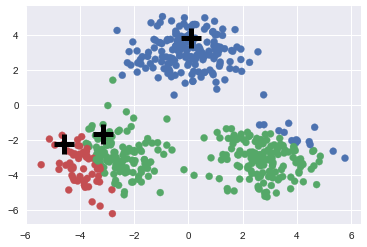

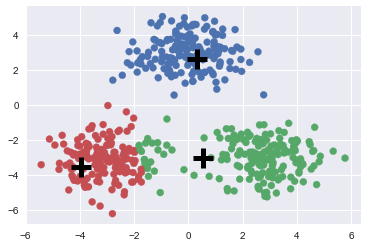

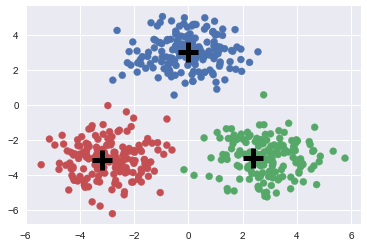

In [29]:
KMeans_fit(data, n_clusters=3, nsteps=0);
KMeans_fit(data, n_clusters=3, nsteps=1);
KMeans_fit(data, n_clusters=3, nsteps=2);

## Clustering in Many Dimensions

We previously looked for clusters where each sample $(x,y)$ was a point in 2D.

What if we treat a whole image as one sample in 256 dimensions (one per pixel)?  Can we find clusters of images in this large dimension?

Recall the parameters of the generative model:
 - Number of sources $N$ = 1-4.
 - $(x_0, y_0, \sigma, e_1, e_2)$ for each source.
 
What might clusters of images correlate with from this list?

To simplify the problem, we will focus on the size ($\sigma$) of images with a single isolated cluster ($N=1$):

In [30]:
df_img = pd.read_hdf('data/sources_img.hf5')
df_par = pd.read_hdf('data/sources_par.hf5')
isolated = df_par['num_source'] == 1
df_iso = df_img[isolated]
sigma = np.concatenate(df_par[isolated]['sigma'].values)

Use the following function to compare the size distributions of isolated sources assigned to different clusters:

In [31]:
def compare_sizes(fit):
    for k in range(fit.n_clusters):
        plt.hist(sigma[fit.labels_ == k], bins=30, range=(0, 3.5),
                 density=True, histtype='step', lw=2, label=f'Cluster #{k}')
    plt.legend()
    return fit

For example:

In [32]:
from sklearn import cluster

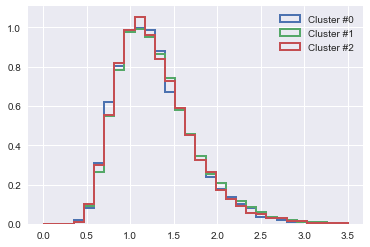

In [33]:
fit = compare_sizes(cluster.KMeans(n_clusters=3, random_state=1).fit(df_iso))

In this example, all 3 clusters have essentially the same distribution of sizes.

### Exercise 5

Look for 10 clusters instead of 3 (again using `random_state=1`). One cluster should be clearly different from the others.

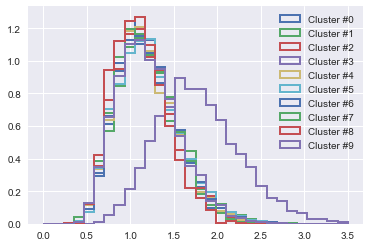

In [34]:
fit = compare_sizes(cluster.KMeans(n_clusters=10, random_state=1).fit(df_iso))

Use `plot_image()` to plot some members of this cluster:

In [35]:
from mls import plot_image

In [36]:
help(plot_image)

Help on function plot_image in module mls.plot:

plot_image(data, size=16, ax=None, label=None, pos_cmap='viridis', neg_cmap='pink')
    Plot a single image of binned data.
    
    Use a sqrt scaling for the pixel colors to improve the dynamic range.
    
    Positive and negative values use different colormaps.
    
    Parameters
    ----------
    data : array
        Array containing pixel data.  Will be reshaped to (size, size).
    size : int
        Number of pixels along each side.
    ax : matplotlib axis or None
        Use the specified axis or the default axis when None.
    label : string or None
        Optional label to display centered at the bottom of the image.
    pos_cmap : matplotlib colormap
        Colormap to use for pixel values >= 0.
    neg_cmap : matplotlib colormap
        Colormap to use for pixel values < 0.



For example:

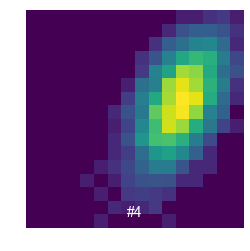

In [37]:
plot_image(df_iso.iloc[4].values, label='#4')

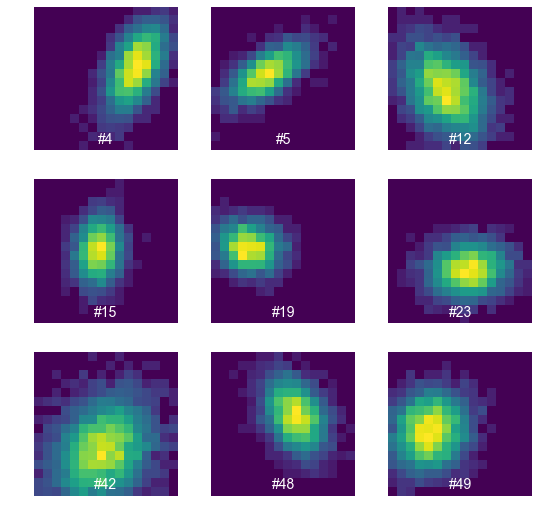

In [38]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9, 9))
for i, k in enumerate(np.where(fit.labels_ == 3)[0][:9]):
    plot_image(df_iso.iloc[k].values, ax=ax[i // 3, i % 3], label=f'#{k}')

Repeat the cluster finding with some different seed values for `random_state`. How robust is this cluster of large sizes?

Here is one example where the cluster of large sizes disappears:

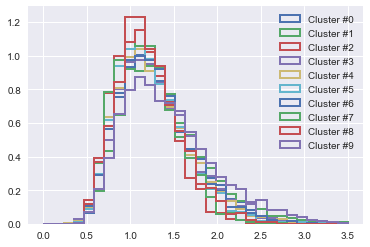

In [39]:
fit = compare_sizes(cluster.KMeans(n_clusters=10, random_state=123).fit(df_iso))

In general, it is difficult to visualize clusters (or anything) in more than 2 dimensions. Your options are to:
- Use attributes such as color and size to display additional dimensions.
- Use 3D visualizations.
- Use an embedding transformation to map high dimensional data to 2D or 3D.

Try the embedding approach by uploading our 256-dimensional data to http://projector.tensorflow.org/. You will first need to save the data in the "tab-separated value" (TSV) format. We will only save the first 1000 images to keep the file size small:

In [40]:
df_iso[:1000].to_csv('data/df_iso.tsv', sep='\t', index=False, header=False)

Experiment with the PCA visualization option, which reduces the dimensionality to 2 or 3 dimensions.

You can also experiment with the [tSNE](https://distill.pub/2016/misread-tsne/) visualizations. These can be hypnotic but I have not found them to be very enlightening for scientific data.